# AMLGentex Framework Tutorial

This notebook demonstrates the complete AMLGentex workflow for synthetic AML detection data generation and federated learning.

## Overview

AMLGentex is a framework for:
1. **Generating** synthetic AML transaction data with configurable patterns
2. **Preprocessing** transactions into ML-ready features
3. **Training** ML models in three settings:
   - **Centralized**: All data combined
   - **Federated**: Privacy-preserving collaborative learning
   - **Isolated**: Each institution trains independently
4. **Visualizing** results and transaction networks

## Convention Over Configuration

The framework follows a **convention-over-configuration** approach:
- Paths are auto-discovered from experiment name
- Clients (banks) are auto-discovered from data
- Results follow standard directory structure

**Standard experiment structure:**
```
experiments/my_experiment/
├── config/
│   ├── data.yaml              # Data generation config
│   ├── preprocessing.yaml     # Feature engineering config
│   └── models.yaml            # Model training config
├── spatial/                   # Generated spatial graph
├── temporal/                  # Generated transactions
├── preprocessed/              # ML-ready features
│   ├── centralized/           # Combined data
│   └── clients/               # Per-bank data
├── results/                   # Training results
│   ├── centralized/
│   ├── federated/
│   └── isolated/
└── visualizations/            # Plots and analysis
```

## Setup

First, let's import the necessary libraries and set up our experiment.

In [1]:
import os
import sys
from pathlib import Path
import yaml
import pickle
import pandas as pd
import matplotlib.pyplot as plt

# Add project root to path
project_root = Path.cwd()
sys.path.insert(0, str(project_root))

# Set experiment name - this is the ONLY thing you need to configure!
EXPERIMENT = "tutorial_demo"
experiment_root = project_root / "experiments" / EXPERIMENT

print(f"Project root: {project_root}")
print(f"Experiment: {EXPERIMENT}")
print(f"Experiment root: {experiment_root}")

Project root: /Users/jostman/Projects/AMLGentex
Experiment: tutorial_demo
Experiment root: /Users/jostman/Projects/AMLGentex/experiments/tutorial_demo


## Step 1: Create Experiment Configuration

We'll create a minimal experiment with 1,000 accounts and 2 banks.

### 1.1 Create Directory Structure

In [2]:
# Create experiment directories
config_dir = experiment_root / "config"
os.makedirs(config_dir, exist_ok=True)

print(f"✓ Created experiment structure at: {experiment_root}")

✓ Created experiment structure at: /Users/jostman/Projects/AMLGentex/experiments/tutorial_demo


### 1.2 Create Data Generation Config

In [3]:
# Instead of creating from scratch, copy the working config from template
import shutil

config_files = ['data.yaml',
                'preprocessing.yaml', 
                'models.yaml']

template_config = project_root / "experiments" / "template_experiment" / "config"

if template_config.exists():
    # Copy the config files
    for f in config_files:
        shutil.copy(template_config / f, config_dir / f)
        print(f"Copied {f} from {template_config}")
    
    # Update simulation_name in data.yaml to match experiment name
    data_yaml_path = config_dir / 'data.yaml'
    with open(data_yaml_path, 'r') as f:
        data_config = yaml.safe_load(f)
    
    data_config['general']['simulation_name'] = EXPERIMENT
    
    with open(data_yaml_path, 'w') as f:
        yaml.dump(data_config, f, default_flow_style=False, sort_keys=False)
    
    print(f"\n✓ Updated simulation_name to: {EXPERIMENT}")
else:
    print("Template config not found. Please ensure template_experiment exists.")

Copied data.yaml from /Users/jostman/Projects/AMLGentex/experiments/template_experiment/config
Copied preprocessing.yaml from /Users/jostman/Projects/AMLGentex/experiments/template_experiment/config
Copied models.yaml from /Users/jostman/Projects/AMLGentex/experiments/template_experiment/config

✓ Updated simulation_name to: tutorial_demo


### 1.3 Create Supporting Configuration Files

We'll copy minimal configuration files from the template experiment.

In [4]:
# Use existing 10k_accounts config as a template for supporting files
template_dir = project_root / "experiments" / "template_experiment" / "config"

# Copy supporting files
import shutil

support_files = [
    'accounts.csv',
    'alertPatterns.csv', 
    'normalModels.csv',
    'degree.csv',
    'transactionType.csv',
    'demographics.csv'  # Required for KYC attribute generation
]

for file in support_files:
    src = template_dir / file
    dst = config_dir / file
    if src.exists():
        shutil.copy(src, dst)
        print(f"✓ Copied {file}")
    else:
        print(f"⚠ Warning: {file} not found in template")

✓ Copied accounts.csv
✓ Copied alertPatterns.csv
✓ Copied normalModels.csv
⚠ Warning: degree.csv not found in template
✓ Copied transactionType.csv
✓ Copied demographics.csv


## Step 2: Generate Synthetic Transaction Data

Now we'll generate synthetic AML transaction data with both normal and suspicious (SAR) patterns.

**Convention**: Paths are automatically constructed from experiment name!

In [5]:
from src.data_creation import DataGenerator
from src.utils.config import load_data_config
import tempfile

# Load config with auto-discovered paths
data_config = load_data_config(str(config_dir / 'data.yaml'))

print("Configuration loaded with auto-discovered paths:")
print(f"  Input dir: {data_config['input']['directory']}")
print(f"  Output dir: {data_config['output']['directory']}")
print()

# DataGenerator expects a config file path, so we create a temporary file
with tempfile.NamedTemporaryFile(mode='w', suffix='.yaml', delete=False) as tmp:
    yaml.dump(data_config, tmp, default_flow_style=False, sort_keys=False)
    tmp_config = tmp.name

try:
    print("Generating synthetic transaction data...")
    print("This may take a few minutes...\n")
    
    generator = DataGenerator(tmp_config, verbose=True)
    # force_spatial=True ensures fresh data generation with latest format
    # (includes demographics-based SALARY, AGE, CITY columns)
    tx_log_file = generator(force_spatial=True)
    
    print(f"\n✓ Transaction data generated: {tx_log_file}")
finally:
    os.unlink(tmp_config)

# Load and inspect the generated data
df = pd.read_parquet(tx_log_file)
print(f"\nGenerated {len(df):,} transactions")
print(f"Banks: {df['bankOrig'].unique().tolist()}")
print(f"SAR transactions: {df['isSAR'].sum():,} ({df['isSAR'].mean()*100:.2f}%)")
print(f"Time range: steps {df['step'].min()} to {df['step'].max()}")

INFO:spatial_simulation.transaction_graph_generator:Random seed: 0
INFO:spatial_simulation.transaction_graph_generator:Simulation name: tutorial_demo
INFO:spatial_simulation.transaction_graph_generator:Add 2124 base transactions
INFO:spatial_simulation.transaction_graph_generator:Generated 1000 accounts.
INFO:spatial_simulation.transaction_graph_generator:Generated 2266 normal models.
INFO:spatial_simulation.transaction_graph_generator:Normal model counts {'single': 500, 'fan_out': 133, 'fan_in': 133, 'forward': 500, 'mutual': 500, 'periodical': 500}
INFO:spatial_simulation.transaction_graph_generator:Assigning demographics-based KYC from /Users/jostman/Projects/AMLGentex/experiments/tutorial_demo/config/demographics.csv...
INFO:spatial_simulation.demographics_assigner:Detected single-year age format
INFO:spatial_simulation.demographics_assigner:Population median monthly salary: 35308 SEK
INFO:spatial_simulation.demographics_assigner:Initialized DemographicsAssigner with 85 age groups


Configuration loaded with auto-discovered paths:
  Input dir: /Users/jostman/Projects/AMLGentex/experiments/tutorial_demo/config
  Output dir: /Users/jostman/Projects/AMLGentex/experiments/tutorial_demo/temporal

Generating synthetic transaction data...
This may take a few minutes...

Running spatial simulation...
  [1/3] Degree distribution found: /Users/jostman/Projects/AMLGentex/experiments/tutorial_demo/config/degree.csv
  [2/3] Generating transaction graph...


INFO:spatial_simulation.ml_account_selector:Computed structural metrics for 1000 nodes
INFO:spatial_simulation.ml_account_selector:Selecting target labels and seeds...
INFO:spatial_simulation.ml_account_selector:Selected 5 target citys: ['city_0' 'city_2' 'city_7' 'city_3' 'city_6']
INFO:spatial_simulation.ml_account_selector:Selected 50 total seeds across 5 target groups
INFO:spatial_simulation.ml_account_selector:Propagating labels via Personalized PageRank toward targets...
INFO:spatial_simulation.ml_account_selector:Combined 5 target PPR fields into 'city_global'
INFO:spatial_simulation.ml_account_selector:Computing final ML selection weights...
INFO:spatial_simulation.ml_account_selector:Computed final weights for 1000 nodes
INFO:spatial_simulation.ml_account_selector:Caching bank-specific weights...
INFO:spatial_simulation.ml_account_selector:Cached weights for 2 banks
INFO:spatial_simulation.ml_account_selector:ML account selector preparation complete
INFO:spatial_simulation.ml_

        Complete (1.51s)
  [3/3] No patterns to insert
Running temporal simulation...
Initialized AMLSimulator: tutorial_demo
Random seed: 0
Total steps: 100
Loading accounts from: /Users/jostman/Projects/AMLGentex/experiments/tutorial_demo/spatial/accounts.csv
Loaded 1000 accounts
Loading transactions from: /Users/jostman/Projects/AMLGentex/experiments/tutorial_demo/spatial/transactions.csv
Loaded 1897 transaction connections
Loading normal models from: /Users/jostman/Projects/AMLGentex/experiments/tutorial_demo/spatial/normal_models.csv
Loaded 6107 normal model entries
Created 2266 normal model objects
Loading alert models from: /Users/jostman/Projects/AMLGentex/experiments/tutorial_demo/spatial/alert_models.csv
Loaded 625 alert memberships
Created 70 alert patterns

Starting AMLSim for 100 steps...
Available banks: 2
Step 0/100
Simulation complete! Generated 53239 transactions
Writing output to: /Users/jostman/Projects/AMLGentex/experiments/tutorial_demo/temporal/tx_log.parquet
Wrot

## Step 2.1: Optimize Data Generation (Optional)

**This step is optional but recommended** - it uses Bayesian optimization to tune data generation parameters to achieve target model performance under operational constraints.

The optimizer uses **two-phase spatial generation**:
1. **Baseline (once)**: Generates normal accounts, graph structure, and demographics
2. **Alert Injection (per trial)**: Loads baseline and injects alerts with trial's ML selector configuration

This allows efficient exploration of ML selector weights without regenerating the entire graph.

### What It Optimizes

**Temporal parameters** (in `optimisation_bounds.temporal`):
- SAR transaction amounts, spending patterns, behavioral features

**ML Selector parameters** (in `optimisation_bounds.ml_selector`):
- Structure weights: How graph centrality influences account selection for SAR patterns
- KYC weights: How account attributes (balance, salary, age) influence selection
- Participation decay: How participation probability decays for multi-pattern accounts

### Optimization Objective

Multi-objective optimization balancing:
1. Utility metric loss: `|achieved_metric - target|`
2. Feature importance variance: Lower variance = more stable features

Results in a **Pareto front** of optimal trade-offs.

### Three Optimization Scenarios

Choose one based on your operational scenario:

**1. Precision@K (Alert Budget Constraint)**
- Use when: Your team can investigate K alerts per day
- Example: "We can review 100 alerts daily. Optimize for 80% precision in top 100."
- Parameters: `constraint_type='K'`, `constraint_value=100`, `utility_metric='precision'`, `target=0.8`

**2. Recall at FPR≤α (Regulatory Constraint)**
- Use when: Compliance requires FPR below a threshold
- Example: "FPR must be ≤1%. Optimize for 70% recall at this limit."
- Parameters: `constraint_type='fpr'`, `constraint_value=0.01`, `utility_metric='recall'`, `target=0.7`

**3. Precision at Recall≥target (Coverage Constraint)**
- Use when: Must detect a minimum fraction of SARs
- Example: "Must detect 70% of SARs. Optimize for 60% precision at this recall."
- Parameters: `constraint_type='recall'`, `constraint_value=0.7`, `utility_metric='precision'`, `target=0.6`

### 2.1.1 Configure and Run Optimization

In [6]:
from src.data_tuning import DataTuner
from src.data_creation import DataGenerator
from src.feature_engineering import DataPreprocessor
from src.utils.config import load_data_config, load_preprocessing_config
import yaml

# ===== CONFIGURE YOUR OPTIMIZATION OBJECTIVE =====
# Choose ONE of the three objectives below:

# Option 1: Precision@K (Alert Budget)
CONSTRAINT_TYPE = 'K'
CONSTRAINT_VALUE = 100  # Top 100 alerts
UTILITY_METRIC = 'precision'
TARGET = 0.02  # only 2% are true positives out of the K reported ones

#Option 2: Recall at FPR (Regulatory Constraint)
# CONSTRAINT_TYPE = 'fpr'
# CONSTRAINT_VALUE = 0.01  # FPR ≤ 1%
# UTILITY_METRIC = 'recall'
# TARGET = 0.02  # 2% recall

# Option 3: Precision at Recall (Coverage Constraint)
# CONSTRAINT_TYPE = 'recall'
# CONSTRAINT_VALUE = 0.7  # Recall ≥ 70%
# UTILITY_METRIC = 'precision'
# TARGET = 0.02  # 2% precision

N_TRIALS = 10  # Number of data optimization trials
N_MODEL_TRIALS = 20  # Number of model hyperparameter trials per data configuration
# ==================================================

print("=" * 60)
print("DATA OPTIMIZATION")
print("=" * 60)
if CONSTRAINT_TYPE == 'K':
    print(f"\nObjective: Optimize {UTILITY_METRIC} in top {int(CONSTRAINT_VALUE)} reported alerts")
elif CONSTRAINT_TYPE == 'fpr':
    print(f"\nObjective: Optimize {UTILITY_METRIC} at FPR ≤ {CONSTRAINT_VALUE}")
elif CONSTRAINT_TYPE == 'recall':
    print(f"\nObjective: Optimize {UTILITY_METRIC} at Recall ≥ {CONSTRAINT_VALUE}")
print(f"Target: {TARGET:.1%} {UTILITY_METRIC}")
print(f"Data optimization trials: {N_TRIALS}")
print(f"Model hyperparameter trials per data config: {N_MODEL_TRIALS}")
print()

# Set up paths
data_yaml_path = str(config_dir / 'data.yaml')

# Load configs with auto-discovered paths
data_config = load_data_config(data_yaml_path)
preproc_config = load_preprocessing_config(str(config_dir / 'preprocessing.yaml'))

# Write config back with absolute paths
with open(data_yaml_path, 'w') as f:
    yaml.dump(data_config, f, default_flow_style=False, sort_keys=False)

# Load model config
with open(config_dir / 'models.yaml', 'r') as f:
    models_config = yaml.safe_load(f)

# Set up optimization directory
bo_dir = experiment_root / 'data_tuning'
os.makedirs(bo_dir, exist_ok=True)

# Create tuning config
tuning_config = {
    'preprocess': preproc_config.copy(),
    **models_config
}
tuning_config['preprocess']['preprocessed_data_dir'] = str(bo_dir / 'preprocessed')
tuning_config['DecisionTreeClassifier']['default']['device'] = 'cpu'

print(f"Optimizer will directly modify: {data_yaml_path}\n")

# Initialize generator
generator = DataGenerator(data_yaml_path, verbose=False)

# Initialize preprocessor
preprocessor = DataPreprocessor(preproc_config, verbose=False)

# Initialize data tuner
print("Initializing data optimizer...")
print("Two-phase generation:")
print("  1. Generate baseline (normal accounts + demographics) - ONCE")
print("  2. For each trial:")
print("     a. Inject alerts from baseline with trial's ML selector weights")
print("     b. Run temporal simulation")
print("     c. Preprocess into features")
print(f"     d. Tune DecisionTreeClassifier hyperparameters ({N_MODEL_TRIALS} trials)")
print(f"     e. Measure {UTILITY_METRIC} and feature stability")
print()

tuner = DataTuner(
    data_conf_file=data_yaml_path,
    config=tuning_config,
    generator=generator,
    preprocessor=preprocessor,
    target=TARGET,
    constraint_type=CONSTRAINT_TYPE,
    constraint_value=CONSTRAINT_VALUE,
    utility_metric=UTILITY_METRIC,
    model='DecisionTreeClassifier',
    bo_dir=str(bo_dir),
    seed=42,
    num_trials_model=N_MODEL_TRIALS,
    verbose=False
)

# Run optimization
print(f"Starting Bayesian optimization ({N_TRIALS} data trials × {N_MODEL_TRIALS} model trials each)...")
print("This may take some time depending on data size and number of trials.\n")

best_trials = tuner(n_trials=N_TRIALS)

print("\n" + "=" * 60)
print("OPTIMIZATION COMPLETE")
print("=" * 60)
print(f"\nFound {len(best_trials)} Pareto-optimal solutions")
print(f"Results saved to: {bo_dir}")
print(f"  - pareto_front.png: Visualization of trade-offs")
print(f"  - best_trials.txt: Parameter values for each solution")
print(f"  - data_tuning_study.db: Full optimization history")
print(f"\nNote: {data_yaml_path} now contains parameters from the last trial.")

DATA OPTIMIZATION

Objective: Optimize precision in top 100 reported alerts
Target: 2.0% precision
Data optimization trials: 10
Model hyperparameter trials per data config: 20

Optimizer will directly modify: /Users/jostman/Projects/AMLGentex/experiments/tutorial_demo/config/data.yaml

Initializing data optimizer...
Two-phase generation:
  1. Generate baseline (normal accounts + demographics) - ONCE
  2. For each trial:
     a. Inject alerts from baseline with trial's ML selector weights
     b. Run temporal simulation
     c. Preprocess into features
     d. Tune DecisionTreeClassifier hyperparameters (20 trials)
     e. Measure precision and feature stability

Starting Bayesian optimization (10 data trials × 20 model trials each)...
This may take some time depending on data size and number of trials.



INFO:spatial_simulation.transaction_graph_generator:Injecting alerts from baseline for tutorial_demo (Phase 2)...
INFO:spatial_simulation.transaction_graph_generator:Random seed: 0
INFO:spatial_simulation.transaction_graph_generator:Simulation name: tutorial_demo
INFO:spatial_simulation.transaction_graph_generator:Loaded baseline checkpoint from /Users/jostman/Projects/AMLGentex/experiments/tutorial_demo/config/baseline_checkpoint.pkl
INFO:spatial_simulation.transaction_graph_generator:Preparing money laundering account selector...
INFO:spatial_simulation.ml_account_selector:Initialized ML Account Selector with config: {'n_target_labels': 5, 'n_seeds_per_target': 10, 'restart_alpha': 0.15, 'seed_strategy': 'degree', 'propagate_labels': ['city'], 'structure_weights': {'degree': 0.4, 'betweenness': 0.3, 'pagerank': 0.8}, 'propagation_weights': {'city': 1.0}, 'kyc_weights': {'init_balance': 0.0, 'salary': 0.0, 'age': 0.0}}
INFO:spatial_simulation.ml_account_selector:Preparing ML account s

Trial 1/10: precision=0.303, loss=0.283


INFO:spatial_simulation.ml_account_selector:Computed structural metrics for 1000 nodes
INFO:spatial_simulation.ml_account_selector:Selecting target labels and seeds...
INFO:spatial_simulation.ml_account_selector:Selected 5 target citys: ['city_8' 'city_1' 'city_3' 'city_0' 'city_4']
INFO:spatial_simulation.ml_account_selector:Selected 50 total seeds across 5 target groups
INFO:spatial_simulation.ml_account_selector:Propagating labels via Personalized PageRank toward targets...
INFO:spatial_simulation.ml_account_selector:Combined 5 target PPR fields into 'city_global'
INFO:spatial_simulation.ml_account_selector:Computing final ML selection weights...
INFO:spatial_simulation.ml_account_selector:Computed final weights for 1000 nodes
INFO:spatial_simulation.ml_account_selector:Caching bank-specific weights...
INFO:spatial_simulation.ml_account_selector:Cached weights for 2 banks
INFO:spatial_simulation.ml_account_selector:ML account selector preparation complete
INFO:spatial_simulation.ml_

Trial 2/10: precision=0.111, loss=0.091


INFO:spatial_simulation.ml_account_selector:Computed structural metrics for 1000 nodes
INFO:spatial_simulation.ml_account_selector:Selecting target labels and seeds...
INFO:spatial_simulation.ml_account_selector:Selected 5 target citys: ['city_8' 'city_1' 'city_3' 'city_0' 'city_4']
INFO:spatial_simulation.ml_account_selector:Selected 50 total seeds across 5 target groups
INFO:spatial_simulation.ml_account_selector:Propagating labels via Personalized PageRank toward targets...
INFO:spatial_simulation.ml_account_selector:Combined 5 target PPR fields into 'city_global'
INFO:spatial_simulation.ml_account_selector:Computing final ML selection weights...
INFO:spatial_simulation.ml_account_selector:Computed final weights for 1000 nodes
INFO:spatial_simulation.ml_account_selector:Caching bank-specific weights...
INFO:spatial_simulation.ml_account_selector:Cached weights for 2 banks
INFO:spatial_simulation.ml_account_selector:ML account selector preparation complete
INFO:spatial_simulation.ml_

Trial 3/10: precision=0.101, loss=0.081


INFO:spatial_simulation.ml_account_selector:Computed structural metrics for 1000 nodes
INFO:spatial_simulation.ml_account_selector:Selecting target labels and seeds...
INFO:spatial_simulation.ml_account_selector:Selected 5 target citys: ['city_8' 'city_1' 'city_3' 'city_0' 'city_4']
INFO:spatial_simulation.ml_account_selector:Selected 50 total seeds across 5 target groups
INFO:spatial_simulation.ml_account_selector:Propagating labels via Personalized PageRank toward targets...
INFO:spatial_simulation.ml_account_selector:Combined 5 target PPR fields into 'city_global'
INFO:spatial_simulation.ml_account_selector:Computing final ML selection weights...
INFO:spatial_simulation.ml_account_selector:Computed final weights for 1000 nodes
INFO:spatial_simulation.ml_account_selector:Caching bank-specific weights...
INFO:spatial_simulation.ml_account_selector:Cached weights for 2 banks
INFO:spatial_simulation.ml_account_selector:ML account selector preparation complete
INFO:spatial_simulation.ml_

Trial 4/10: precision=0.152, loss=0.132


INFO:spatial_simulation.ml_account_selector:Computed structural metrics for 1000 nodes
INFO:spatial_simulation.ml_account_selector:Selecting target labels and seeds...
INFO:spatial_simulation.ml_account_selector:Selected 5 target citys: ['city_8' 'city_1' 'city_3' 'city_0' 'city_4']
INFO:spatial_simulation.ml_account_selector:Selected 50 total seeds across 5 target groups
INFO:spatial_simulation.ml_account_selector:Propagating labels via Personalized PageRank toward targets...
INFO:spatial_simulation.ml_account_selector:Combined 5 target PPR fields into 'city_global'
INFO:spatial_simulation.ml_account_selector:Computing final ML selection weights...
INFO:spatial_simulation.ml_account_selector:Computed final weights for 1000 nodes
INFO:spatial_simulation.ml_account_selector:Caching bank-specific weights...
INFO:spatial_simulation.ml_account_selector:Cached weights for 2 banks
INFO:spatial_simulation.ml_account_selector:ML account selector preparation complete
INFO:spatial_simulation.ml_

Trial 5/10: precision=0.131, loss=0.111


INFO:spatial_simulation.ml_account_selector:Computed structural metrics for 1000 nodes
INFO:spatial_simulation.ml_account_selector:Selecting target labels and seeds...
INFO:spatial_simulation.ml_account_selector:Selected 5 target citys: ['city_8' 'city_1' 'city_3' 'city_0' 'city_4']
INFO:spatial_simulation.ml_account_selector:Selected 50 total seeds across 5 target groups
INFO:spatial_simulation.ml_account_selector:Propagating labels via Personalized PageRank toward targets...
INFO:spatial_simulation.ml_account_selector:Combined 5 target PPR fields into 'city_global'
INFO:spatial_simulation.ml_account_selector:Computing final ML selection weights...
INFO:spatial_simulation.ml_account_selector:Computed final weights for 1000 nodes
INFO:spatial_simulation.ml_account_selector:Caching bank-specific weights...
INFO:spatial_simulation.ml_account_selector:Cached weights for 2 banks
INFO:spatial_simulation.ml_account_selector:ML account selector preparation complete
INFO:spatial_simulation.ml_

Trial 6/10: precision=0.152, loss=0.132


INFO:spatial_simulation.ml_account_selector:Computed structural metrics for 1000 nodes
INFO:spatial_simulation.ml_account_selector:Selecting target labels and seeds...
INFO:spatial_simulation.ml_account_selector:Selected 5 target citys: ['city_8' 'city_1' 'city_3' 'city_0' 'city_4']
INFO:spatial_simulation.ml_account_selector:Selected 50 total seeds across 5 target groups
INFO:spatial_simulation.ml_account_selector:Propagating labels via Personalized PageRank toward targets...
INFO:spatial_simulation.ml_account_selector:Combined 5 target PPR fields into 'city_global'
INFO:spatial_simulation.ml_account_selector:Computing final ML selection weights...
INFO:spatial_simulation.ml_account_selector:Computed final weights for 1000 nodes
INFO:spatial_simulation.ml_account_selector:Caching bank-specific weights...
INFO:spatial_simulation.ml_account_selector:Cached weights for 2 banks
INFO:spatial_simulation.ml_account_selector:ML account selector preparation complete
INFO:spatial_simulation.ml_

Trial 7/10: precision=0.253, loss=0.233


INFO:spatial_simulation.ml_account_selector:Computed structural metrics for 1000 nodes
INFO:spatial_simulation.ml_account_selector:Selecting target labels and seeds...
INFO:spatial_simulation.ml_account_selector:Selected 5 target citys: ['city_8' 'city_1' 'city_3' 'city_0' 'city_4']
INFO:spatial_simulation.ml_account_selector:Selected 50 total seeds across 5 target groups
INFO:spatial_simulation.ml_account_selector:Propagating labels via Personalized PageRank toward targets...
INFO:spatial_simulation.ml_account_selector:Combined 5 target PPR fields into 'city_global'
INFO:spatial_simulation.ml_account_selector:Computing final ML selection weights...
INFO:spatial_simulation.ml_account_selector:Computed final weights for 1000 nodes
INFO:spatial_simulation.ml_account_selector:Caching bank-specific weights...
INFO:spatial_simulation.ml_account_selector:Cached weights for 2 banks
INFO:spatial_simulation.ml_account_selector:ML account selector preparation complete
INFO:spatial_simulation.ml_

Trial 8/10: precision=0.111, loss=0.091


INFO:spatial_simulation.ml_account_selector:Computed structural metrics for 1000 nodes
INFO:spatial_simulation.ml_account_selector:Selecting target labels and seeds...
INFO:spatial_simulation.ml_account_selector:Selected 5 target citys: ['city_8' 'city_1' 'city_3' 'city_0' 'city_4']
INFO:spatial_simulation.ml_account_selector:Selected 50 total seeds across 5 target groups
INFO:spatial_simulation.ml_account_selector:Propagating labels via Personalized PageRank toward targets...
INFO:spatial_simulation.ml_account_selector:Combined 5 target PPR fields into 'city_global'
INFO:spatial_simulation.ml_account_selector:Computing final ML selection weights...
INFO:spatial_simulation.ml_account_selector:Computed final weights for 1000 nodes
INFO:spatial_simulation.ml_account_selector:Caching bank-specific weights...
INFO:spatial_simulation.ml_account_selector:Cached weights for 2 banks
INFO:spatial_simulation.ml_account_selector:ML account selector preparation complete
INFO:spatial_simulation.ml_

Trial 9/10: precision=0.212, loss=0.192


INFO:spatial_simulation.ml_account_selector:Computed structural metrics for 1000 nodes
INFO:spatial_simulation.ml_account_selector:Selecting target labels and seeds...
INFO:spatial_simulation.ml_account_selector:Selected 5 target citys: ['city_8' 'city_1' 'city_3' 'city_0' 'city_4']
INFO:spatial_simulation.ml_account_selector:Selected 50 total seeds across 5 target groups
INFO:spatial_simulation.ml_account_selector:Propagating labels via Personalized PageRank toward targets...
INFO:spatial_simulation.ml_account_selector:Combined 5 target PPR fields into 'city_global'
INFO:spatial_simulation.ml_account_selector:Computing final ML selection weights...
INFO:spatial_simulation.ml_account_selector:Computed final weights for 1000 nodes
INFO:spatial_simulation.ml_account_selector:Caching bank-specific weights...
INFO:spatial_simulation.ml_account_selector:Cached weights for 2 banks
INFO:spatial_simulation.ml_account_selector:ML account selector preparation complete
INFO:spatial_simulation.ml_

Trial 10/10: precision=0.192, loss=0.172

Data tuning results saved to: /Users/jostman/Projects/AMLGentex/experiments/tutorial_demo/data_tuning
  - Database: data_tuning_study.db
  - Pareto front: pareto_front.png
  - Best trials: best_trials.txt

OPTIMIZATION COMPLETE

Found 7 Pareto-optimal solutions
Results saved to: /Users/jostman/Projects/AMLGentex/experiments/tutorial_demo/data_tuning
  - pareto_front.png: Visualization of trade-offs
  - best_trials.txt: Parameter values for each solution
  - data_tuning_study.db: Full optimization history

Note: /Users/jostman/Projects/AMLGentex/experiments/tutorial_demo/config/data.yaml now contains parameters from the last trial.


### 2.1.2 Visualize Pareto Front and Select Solution

The optimizer returns multiple Pareto-optimal solutions. Each represents a different trade-off:
- **Low FPR loss** = data closely matches target FPR
- **Low feature importance loss** = more stable/consistent features

Let's visualize the results and select the best trial.

In [6]:
# Display Pareto front
from IPython.display import Image, display

pareto_front_path = bo_dir / 'pareto_front.png'
if pareto_front_path.exists():
    display(Image(filename=str(pareto_front_path)))
else:
    print("Pareto front plot not found")

# Show best trials
print("\n" + "=" * 60)
print("PARETO-OPTIMAL SOLUTIONS")
print("=" * 60)

for i, trial in enumerate(best_trials):
    utility_loss = trial.values[0]
    importance_loss = trial.values[1]
    
    # Get achieved utility from trial attributes
    achieved_utility = trial.user_attrs.get('utility_metric', TARGET)
    
    print(f"\nTrial {trial.number} (Solution #{i+1}):")
    print(f"  {UTILITY_METRIC.capitalize()}: {achieved_utility:.4f} (target: {TARGET:.4f}, loss: {utility_loss:.4f})")
    print(f"  Feature stability loss: {importance_loss:.4f}")
    print(f"  Parameters:")
    for param, value in trial.params.items():
        if isinstance(value, float):
            print(f"    {param}: {value:.4f}")
        else:
            print(f"    {param}: {value}")

print("\n" + "=" * 60)
print("RECOMMENDATION")
print("=" * 60)
print("\nTo select a trial:")
print(f"  1. Low {UTILITY_METRIC} loss = better match to target")
print("  2. Low importance loss = more stable features")
print("  3. Balance both for general use")
print(f"\nTrial {best_trials[0].number} has the best balance")
print(f"Run next cell to apply it (or choose a different trial number)")

NameError: name 'bo_dir' is not defined

### 2.1.3 Apply Selected Trial and Regenerate Data

Choose which trial to use and regenerate the data with optimized parameters.

In [7]:
# ===== SELECT WHICH TRIAL TO USE =====
SELECTED_TRIAL = best_trials[0].number  # Default: use first (best balance)
# You can change this to any trial number from the list above
# ======================================

print("=" * 60)
print("APPLYING OPTIMIZED PARAMETERS")
print("=" * 60)

# Update data.yaml with selected trial's parameters
tuner.optimizer.update_config_with_trial(SELECTED_TRIAL)

# Regenerate data with optimized parameters
print("\nRegenerating data with optimized parameters...")
print("This may take a few minutes...\n")

# Reload config and regenerate
data_config_optimized = load_data_config(data_yaml_path)
with open(data_yaml_path, 'w') as f:
    yaml.dump(data_config_optimized, f, default_flow_style=False, sort_keys=False)

# Reinitialize generator with updated config
generator = DataGenerator(data_yaml_path)
optimized_tx_log = generator()

print(f"\n✓ Optimized transaction data generated: {optimized_tx_log}")

# Load and inspect the optimized data
df_optimized = pd.read_parquet(optimized_tx_log)
print(f"\nGenerated {len(df_optimized):,} transactions")
print(f"Banks: {df_optimized['bankOrig'].unique().tolist()}")
print(f"SAR transactions: {df_optimized['isSAR'].sum():,} ({df_optimized['isSAR'].mean()*100:.2f}%)")
print(f"Time range: steps {df_optimized['step'].min()} to {df_optimized['step'].max()}")

# Compare with original (if available)
if 'df' in globals():
    print("\n" + "=" * 60)
    print("COMPARISON: Original vs Optimized")
    print("=" * 60)
    print(f"  Total transactions: {len(df):,} → {len(df_optimized):,}")
    print(f"  SAR rate: {df['isSAR'].mean()*100:.2f}% → {df_optimized['isSAR'].mean()*100:.2f}%")

print("\n✅ Data optimization complete!")
if CONSTRAINT_TYPE == 'K':
    print(f"The optimized data should achieve ~{TARGET:.1%} {UTILITY_METRIC} in top {int(CONSTRAINT_VALUE)} alerts.")
elif CONSTRAINT_TYPE == 'fpr':
    print(f"The optimized data should achieve ~{TARGET:.1%} {UTILITY_METRIC} at FPR ≤ {CONSTRAINT_VALUE}.")
elif CONSTRAINT_TYPE == 'recall':
    print(f"The optimized data should achieve ~{TARGET:.1%} {UTILITY_METRIC} at Recall ≥ {CONSTRAINT_VALUE}.")
print(f"\nProceed to Step 3 to preprocess this optimized data.")

NameError: name 'best_trials' is not defined

---

**Note about Step 2.1:**
- **If you ran optimization**: The data has been regenerated with optimized parameters. Proceed to Step 3.
- **If you skipped optimization**: You can proceed directly to Step 3 with the original data from Step 2.

The optimization step tunes two categories of parameters:

**1. Temporal parameters** (transaction behaviors):
- SAR amounts, spending patterns, behavioral timing

**2. ML Selector parameters** (account selection for SAR patterns):
- Structure weights: degree, betweenness, pagerank centrality
- KYC weights: balance, salary, age
- Participation decay for multi-pattern accounts

This is particularly useful when:
- **Precision@K**: You have a fixed alert review budget and need high precision
- **Recall at FPR**: Regulatory requirements constrain false positive rates
- **Precision at Recall**: You must maintain minimum SAR detection coverage

---

## Step 3: Preprocess Data for ML

Convert raw transactions into ML-ready features with graph structure.

**Convention**: Creates both centralized and per-client datasets automatically!

In [8]:
from src.feature_engineering import DataPreprocessor, summarize_dataset
from src.utils.config import load_preprocessing_config

# Copy the preprocessing.yaml from template
template_dir = project_root / "experiments" / "template_experiment" / "config"

# Load config with auto-discovered paths
preproc_config = load_preprocessing_config(str(config_dir / 'preprocessing.yaml'))

print("Preprocessing configuration:")
print(f"  Raw data: {preproc_config['raw_data_file']}")
print(f"  Output dir: {preproc_config['preprocessed_data_dir']}")
print()

print("Preprocessing transactions...")
print("Generating temporal features with rolling windows...\n")

preprocessor = DataPreprocessor(preproc_config)
datasets = preprocessor(preproc_config['raw_data_file'])

# =============================================================================
# PATTERN DISTRIBUTION ANALYSIS
# =============================================================================
# Check how SAR patterns are distributed across train/val/test splits
# This helps identify potential data leakage if patterns appear in multiple splits

print("\n" + "=" * 60)
print("PATTERN DISTRIBUTION ACROSS SPLITS")
print("=" * 60)

# Load raw transaction data to get pattern IDs
raw_df = pd.read_parquet(preproc_config['raw_data_file'])

# Get SAR accounts and their patterns (use nameOrig for account-level patterns)
sar_txs = raw_df[raw_df['isSAR'] == 1][['nameOrig', 'patternID']].drop_duplicates()
account_to_pattern = dict(zip(sar_txs['nameOrig'], sar_txs['patternID']))

# For transductive mode, use masks to identify splits
df_nodes = datasets['trainset_nodes']

if 'train_mask' in df_nodes.columns:
    # Transductive mode - use masks
    train_accounts = df_nodes[df_nodes['train_mask']]['account'].tolist()
    val_accounts = df_nodes[df_nodes['val_mask']]['account'].tolist()
    test_accounts = df_nodes[df_nodes['test_mask']]['account'].tolist()
else:
    # Inductive mode - different dataframes per split
    train_accounts = datasets['trainset_nodes']['account'].tolist()
    val_accounts = datasets['valset_nodes']['account'].tolist()
    test_accounts = datasets['testset_nodes']['account'].tolist()

# Get patterns for each split (only SAR accounts have patterns)
train_patterns = set(account_to_pattern.get(acc) for acc in train_accounts if acc in account_to_pattern)
val_patterns = set(account_to_pattern.get(acc) for acc in val_accounts if acc in account_to_pattern)
test_patterns = set(account_to_pattern.get(acc) for acc in test_accounts if acc in account_to_pattern)

# Remove None values
train_patterns.discard(None)
val_patterns.discard(None)
test_patterns.discard(None)

print(f"\nUnique SAR patterns per split:")
print(f"  Train: {len(train_patterns)} patterns")
print(f"  Val:   {len(val_patterns)} patterns")
print(f"  Test:  {len(test_patterns)} patterns")

# Check for overlap (potential data leakage)
train_val_overlap = train_patterns & val_patterns
train_test_overlap = train_patterns & test_patterns
val_test_overlap = val_patterns & test_patterns

if train_val_overlap or train_test_overlap or val_test_overlap:
    print(f"\n⚠️  PATTERN OVERLAP DETECTED (potential data leakage):")
    if train_val_overlap:
        print(f"  Train ∩ Val:  {len(train_val_overlap)} patterns")
    if train_test_overlap:
        print(f"  Train ∩ Test: {len(train_test_overlap)} patterns")
    if val_test_overlap:
        print(f"  Val ∩ Test:   {len(val_test_overlap)} patterns")
    print(f"\n  Tip: Enable 'split_by_pattern: true' in preprocessing.yaml")
    print(f"       to prevent the same pattern appearing in multiple splits.")
else:
    print(f"\n✓ No pattern overlap - each pattern appears in only one split")

print("=" * 60)

# =============================================================================
# SAVE PREPROCESSED DATA
# =============================================================================

# Create directory structure
preprocessed_dir = Path(preproc_config['preprocessed_data_dir'])
os.makedirs(preprocessed_dir / 'centralized', exist_ok=True)
os.makedirs(preprocessed_dir / 'clients', exist_ok=True)

# Save centralized datasets
for name, dataset in datasets.items():
    dataset.to_parquet(preprocessed_dir / 'centralized' / f'{name}.parquet', index=False)
    print(f"  Saved centralized/{name}.parquet: {len(dataset):,} samples")

# Split by bank and save per-client datasets
banks = datasets['trainset_nodes']['bank'].unique()
print(f"\nSplitting data for {len(banks)} banks: {banks.tolist()}")

for bank in banks:
    bank_str = str(bank)
    bank_dir = preprocessed_dir / 'clients' / bank_str
    os.makedirs(bank_dir, exist_ok=True)
    
    # Save nodes
    for split in ['trainset', 'valset', 'testset']:
        df_nodes = datasets[f'{split}_nodes']
        df_nodes[df_nodes['bank'] == bank].to_parquet(
            bank_dir / f'{split}_nodes.parquet', index=False
        )
    
    # Save edges (only intra-bank transactions)
    if 'trainset_edges' in datasets:
        for split in ['trainset', 'valset', 'testset']:
            unique_nodes = df_nodes[df_nodes['bank'] == bank]['account'].unique()
            df_edges = datasets[f'{split}_edges']
            df_edges[
                (df_edges['src'].isin(unique_nodes)) & 
                (df_edges['dst'].isin(unique_nodes))
            ].to_parquet(bank_dir / f'{split}_edges.parquet', index=False)
    
    print(f"  ✓ Saved data for bank: {bank_str}")

# Generate summary statistics
print("\nGenerating dataset summary...")
summarize_dataset(
    str(preprocessed_dir),
    raw_data_file=preproc_config['raw_data_file']
)

print("\n✅ Preprocessing complete!")

Preprocessing configuration:
  Raw data: /Users/jostman/Projects/AMLGentex/experiments/tutorial_demo/temporal/tx_log.parquet
  Output dir: /Users/jostman/Projects/AMLGentex/experiments/tutorial_demo/preprocessed

Preprocessing transactions...
Generating temporal features with rolling windows...


Preprocessing data...Warning: Windows cover 100/101 steps. Using non-overlapping windows.

Transductive label splitting (random):
  Total nodes: 991, SAR nodes: 381, Normal nodes: 610
  Train: 228 SAR + 366 normal = 594
  Val:   76 SAR + 122 normal = 198
  Test:  77 SAR + 122 normal = 199
Loaded static features for 1000 accounts: ['account', 'age', 'salary', 'city', 'init_balance']
 done


PATTERN DISTRIBUTION ACROSS SPLITS

Unique SAR patterns per split:
  Train: 55 patterns
  Val:   34 patterns
  Test:  33 patterns

⚠️  PATTERN OVERLAP DETECTED (potential data leakage):
  Train ∩ Val:  29 patterns
  Train ∩ Test: 31 patterns
  Val ∩ Test:   21 patterns

  Tip: Enable 'split_by_pattern: true'

## Step 4: Train ML Models

Train a Graph Neural Network (GraphSAGE) in three different settings.

**Convention**: All paths and clients are auto-discovered!

### 4.1 Centralized Training

Train on all data combined (baseline).

In [9]:
from src.ml.training.centralized import centralized
from src.ml import clients, models
from src.utils.config import load_training_config
import pandas as pd

print("=" * 60)
print("CENTRALIZED TRAINING - GraphSAGE")
print("=" * 60)

# NOTE: Even if models.yaml contains multiple model configurations,
# we only load GraphSAGE here by specifying it as the model_type parameter
config = load_training_config(
    str(config_dir / 'models.yaml'),
    'GraphSAGE',  # Selects only GraphSAGE config from models.yaml
    setting='centralized',
    client_type='TorchGeometricClient'
)

# Force CPU device (override config if needed)
config['device'] = 'cpu'

print(f"\nTraining GraphSAGE on centralized data:")
print(f"  Device: {config['device']}")
print(f"  Nodes: {config['trainset_nodes']}")
print(f"  Edges: {config['trainset_edges']}")
print()

# NOTE: input_dim is automatically detected from the data by the client
# No need to manually calculate it!

# Train GraphSAGE model
Client = getattr(clients, 'TorchGeometricClient')
Model = getattr(models, 'GraphSAGE')

results_centralized = centralized(
    seed=42,
    Client=Client,
    Model=Model,
    **config
)

# Save results
results_dir = experiment_root / 'results' / 'centralized' / 'GraphSAGE'
os.makedirs(results_dir, exist_ok=True)
with open(results_dir / 'results.pkl', 'wb') as f:
    pickle.dump(results_centralized, f)

# Display final metrics
for client_id, metrics in results_centralized.items():
    print(f"\n{client_id} - Final Metrics:")
    print(f"  Test Average Precision: {metrics['testset']['average_precision'][-1]:.4f}")
    print(f"  Test F1: {metrics['testset']['f1'][-1]:.4f}")

print(f"\n✓ Results saved to: {results_dir}")

CENTRALIZED TRAINING - GraphSAGE

Training GraphSAGE on centralized data:
  Device: cpu
  Nodes: /Users/jostman/Projects/AMLGentex/experiments/tutorial_demo/preprocessed/centralized/trainset_nodes.parquet
  Edges: /Users/jostman/Projects/AMLGentex/experiments/tutorial_demo/preprocessed/centralized/trainset_edges.parquet




cen - Final Metrics:
  Test Average Precision: 0.0315
  Test F1: 0.0500

✓ Results saved to: /Users/jostman/Projects/AMLGentex/experiments/tutorial_demo/results/centralized/GraphSAGE


### 4.2 Federated Training

Privacy-preserving collaborative learning across banks.

In [10]:
from src.ml.training.federated import federated
from src.ml import servers

print("=" * 60)
print("FEDERATED TRAINING - GraphSAGE")
print("=" * 60)

# NOTE: Even if models.yaml contains multiple model configurations,
# we only load GraphSAGE here by specifying it as the model_type parameter
config = load_training_config(
    str(config_dir / 'models.yaml'),
    'GraphSAGE',  # Selects only GraphSAGE config from models.yaml
    setting='federated',
    client_type='TorchGeometricClient'
)

# Force CPU device (override config if needed)
config['device'] = 'cpu'

print(f"\nAuto-discovered clients: {list(config['clients'].keys())}")
for client_id, client_config in config['clients'].items():
    print(f"  {client_id}:")
    print(f"    Nodes: {client_config['trainset_nodes']}")

print(f"\nDevice: {config['device']}")
print()

# NOTE: input_dim is automatically detected from the data by the client
# No need to manually calculate it!

# Train GraphSAGE model with federated learning
Server = getattr(servers, 'TorchServer')
Client = getattr(clients, 'TorchGeometricClient')
Model = getattr(models, 'GraphSAGE')

results_federated = federated(
    seed=42,
    Server=Server,
    Client=Client,
    Model=Model,
    n_workers=2,
    **config
)

# Save results
results_dir = experiment_root / 'results' / 'federated' / 'GraphSAGE'
os.makedirs(results_dir, exist_ok=True)
with open(results_dir / 'results.pkl', 'wb') as f:
    pickle.dump(results_federated, f)

# Display final metrics
print("\nFinal Metrics (per client):")
for client_id, metrics in results_federated.items():
    print(f"\n{client_id}:")
    print(f"  Test Average Precision: {metrics['testset']['average_precision'][-1]:.4f}")
    print(f"  Test F1: {metrics['testset']['f1'][-1]:.4f}")

print(f"\n✓ Results saved to: {results_dir}")

FEDERATED TRAINING - GraphSAGE

Auto-discovered clients: ['handelsbanken', 'swedbank']
  handelsbanken:
    Nodes: /Users/jostman/Projects/AMLGentex/experiments/tutorial_demo/preprocessed/clients/handelsbanken/trainset_nodes.parquet
  swedbank:
    Nodes: /Users/jostman/Projects/AMLGentex/experiments/tutorial_demo/preprocessed/clients/swedbank/trainset_nodes.parquet

Device: cpu

Server: Using input_dim=204 from client (config had 94)



Final Metrics (per client):

handelsbanken:
  Test Average Precision: 0.0270
  Test F1: 0.0500

swedbank:
  Test Average Precision: 0.0629
  Test F1: 0.1071

✓ Results saved to: /Users/jostman/Projects/AMLGentex/experiments/tutorial_demo/results/federated/GraphSAGE


### 4.3 Isolated Training

Each bank trains independently on their own data.

In [11]:
from src.ml.training.isolated import isolated

print("=" * 60)
print("ISOLATED TRAINING - GraphSAGE")
print("=" * 60)

# NOTE: Even if models.yaml contains multiple model configurations,
# we only load GraphSAGE here by specifying it as the model_type parameter
config = load_training_config(
    str(config_dir / 'models.yaml'),
    'GraphSAGE',  # Selects only GraphSAGE config from models.yaml
    setting='isolated',
    client_type='TorchGeometricClient'
)

# Force CPU device (override config if needed)
config['device'] = 'cpu'

print(f"\nTraining isolated GraphSAGE models for: {list(config['clients'].keys())}")
print(f"Device: {config['device']}")
print()

# NOTE: input_dim is automatically detected from the data by the client
# No need to manually calculate it!

# Train GraphSAGE models independently
Client = getattr(clients, 'TorchGeometricClient')
Model = getattr(models, 'GraphSAGE')

results_isolated = isolated(
    seed=42,
    Client=Client,
    Model=Model,
    n_workers=2,
    **config
)

# Save results
results_dir = experiment_root / 'results' / 'isolated' / 'GraphSAGE'
os.makedirs(results_dir, exist_ok=True)
with open(results_dir / 'results.pkl', 'wb') as f:
    pickle.dump(results_isolated, f)

# Display final metrics
print("\nFinal Metrics (per client):")
for client_id, metrics in results_isolated.items():
    print(f"\n{client_id}:")
    print(f"  Test Average Precision: {metrics['testset']['average_precision'][-1]:.4f}")
    print(f"  Test F1: {metrics['testset']['f1'][-1]:.4f}")

print(f"\n✓ Results saved to: {results_dir}")
print("\n✅ All training complete!")

ISOLATED TRAINING - GraphSAGE

Training isolated GraphSAGE models for: ['handelsbanken', 'swedbank']
Device: cpu




Final Metrics (per client):

handelsbanken:
  Test Average Precision: 0.0323
  Test F1: 0.0294

swedbank:
  Test Average Precision: 0.0418
  Test F1: 0.0755

✓ Results saved to: /Users/jostman/Projects/AMLGentex/experiments/tutorial_demo/results/isolated/GraphSAGE

✅ All training complete!


## Step 5: Visualize Results

Compare performance across the three training settings.

### 5.1 Generate Plots

In [12]:
from src.visualize import plot_metrics
from src.visualize.utils import discover_results, load_results

print("=" * 60)
print("VISUALIZATION")
print("=" * 60)

# Auto-discover all results
results_files = discover_results(experiment_root)

print(f"\nFound {len(results_files)} results file(s):")
for key in results_files:
    print(f"  - {key}")

# Generate plots for each
print("\nGenerating plots...")
for key, results_file in results_files.items():
    print(f"  Processing {key}...")
    data = load_results(results_file)
    output_dir = results_file.parent
    
    plot_metrics(
        data,
        str(output_dir),
        metrics=['average_precision', 'f1', 'loss'],
        clients=None,
        datasets=['trainset', 'valset', 'testset'],
        reduction='mean',
        formats=['png']
    )
    print(f"    Saved plots to: {output_dir}/png/")

print("\n✓ All plots generated!")

VISUALIZATION

Found 3 results file(s):
  - centralized/GraphSAGE
  - federated/GraphSAGE
  - isolated/GraphSAGE

Generating plots...
  Processing centralized/GraphSAGE...
    Saved plots to: /Users/jostman/Projects/AMLGentex/experiments/tutorial_demo/results/centralized/GraphSAGE/png/
  Processing federated/GraphSAGE...
    Saved plots to: /Users/jostman/Projects/AMLGentex/experiments/tutorial_demo/results/federated/GraphSAGE/png/
  Processing isolated/GraphSAGE...
    Saved plots to: /Users/jostman/Projects/AMLGentex/experiments/tutorial_demo/results/isolated/GraphSAGE/png/

✓ All plots generated!


### 5.2 Compare Results


PERFORMANCE COMPARISON

Setting         Avg Precision   F1 Score       
---------------------------------------------
Centralized     0.0315          0.0500         
Federated       0.0449          0.0786         
Isolated        0.0370          0.0524         

✓ Comparison plot saved to: /Users/jostman/Projects/AMLGentex/experiments/tutorial_demo/visualizations/comparison/setting_comparison.png


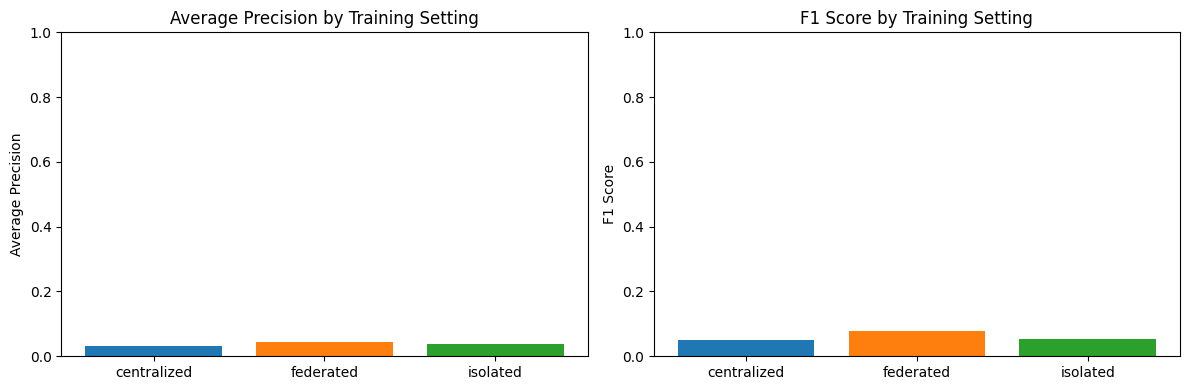

In [13]:
# Load all results and compare
import numpy as np

comparison = {}

for setting in ['centralized', 'federated', 'isolated']:
    results_file = experiment_root / 'results' / setting / 'GraphSAGE' / 'results.pkl'
    if results_file.exists():
        with open(results_file, 'rb') as f:
            results = pickle.load(f)
        
        # Average across clients
        avg_ap = np.mean([r['testset']['average_precision'][-1] for r in results.values()])
        avg_f1 = np.mean([r['testset']['f1'][-1] for r in results.values()])
        
        comparison[setting] = {
            'Average Precision': avg_ap,
            'F1 Score': avg_f1
        }

# Display comparison
print("\n" + "=" * 60)
print("PERFORMANCE COMPARISON")
print("=" * 60)
print(f"\n{'Setting':<15} {'Avg Precision':<15} {'F1 Score':<15}")
print("-" * 45)
for setting, metrics in comparison.items():
    print(f"{setting.capitalize():<15} {metrics['Average Precision']:<15.4f} {metrics['F1 Score']:<15.4f}")

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

settings = list(comparison.keys())
ap_scores = [comparison[s]['Average Precision'] for s in settings]
f1_scores = [comparison[s]['F1 Score'] for s in settings]

axes[0].bar(settings, ap_scores, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[0].set_ylabel('Average Precision')
axes[0].set_title('Average Precision by Training Setting')
axes[0].set_ylim(0, 1)

axes[1].bar(settings, f1_scores, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[1].set_ylabel('F1 Score')
axes[1].set_title('F1 Score by Training Setting')
axes[1].set_ylim(0, 1)

plt.tight_layout()

# Save comparison plot
comparison_dir = experiment_root / 'visualizations' / 'comparison'
os.makedirs(comparison_dir, exist_ok=True)
plt.savefig(comparison_dir / 'setting_comparison.png', dpi=150)
print(f"\n✓ Comparison plot saved to: {comparison_dir / 'setting_comparison.png'}")
plt.show()

### 6 Interactive Network Explorer Dashboard

For interactive exploration of the data with filtering by banks, transaction models, and time ranges, use the standalone dashboard:

```bash
# Install network-explorer dependencies if not already installed
uv sync --extra network-explorer

# Run the dashboard
uv run python src/visualize/transaction_network_explorer/dashboard.py --experiment tutorial_demo
```

Then open http://localhost:5006 in your browser.

The dashboard provides:
- **Bank Filtering**: Select which banks to include
- **Transaction Model Filtering**: Choose specific laundering and legitimate patterns
- **Time Range Selection**: Focus on specific time periods
- **Multiple Visualizations**: Amount distributions, degree distributions, and temporal patterns

All visualizations update in real-time as you adjust the filters.

## Summary

Congratulations! You've completed a full workflow through the AMLGentex framework:

✅ **Created** an experiment with minimal configuration  
✅ **Generated** synthetic AML transaction data  
✅ **Preprocessed** transactions into ML-ready features  
✅ **Trained** models in three settings (centralized, federated, isolated)  
✅ **Visualized** and compared results  
✅ **Explored** transactions with interactive widgets  

### Key Takeaways

1. **Convention over Configuration**: By following standard directory structure, the framework auto-discovers paths and clients
2. **Privacy-Preserving Learning**: Federated learning enables collaboration without sharing raw data
3. **Flexible Architecture**: Easy to compare different training paradigms
4. **Scalable**: Framework handles small demos to large-scale experiments

### Next Steps

- **Experiment with different models**: Try GCN, GAT, MLP, or tree-based models
- **Optimize hyperparameters**: Use `scripts/tune_hyperparams.py` for Bayesian optimization
- **Scale up**: Create larger experiments with more accounts and banks
- **Customize patterns**: Modify SAR transaction patterns in config files
- **Analyze results**: Use the visualization tools to understand model behavior

### Documentation

- **ML Module**: `src/ml/README.md`
- **Scripts**: `scripts/README.md`
- **Project**: `README.md`

### Command-Line Usage

All steps can also be run from the command line:

```bash
# Generate data
python scripts/generate.py --conf_file experiments/tutorial_demo/config/data.yaml

# Preprocess
python scripts/preprocess.py --config experiments/tutorial_demo/config/preprocessing.yaml

# Train (centralized)
python -m src.ml.training.centralized \
  --config experiments/tutorial_demo/config/models.yaml \
  --model_type GraphSAGE \
  --client_type TorchGeometricClient

# Visualize
python scripts/plot.py --experiment tutorial_demo
```